<a href="https://colab.research.google.com/github/claudiobarril/aprendizaje_profundo/blob/main/Deep_Learning_TP_Cohorte_17_5B2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Universidad de Buenos Aires
# Deep Learning - TP
# Cohorte 17 - 5to bimestre 2024


El TP comienza al momento de recibir este correo y la ventana de entrega estará abierta hasta **las 20hs del Lunes 03 de diciembre**. La resolución es individual. Pueden utilizar los contenidos vistos en clase y otra bibliografía. Si se toman ideas de fuentes externas deben ser correctamente citadas incluyendo el correspondiente link o página de libro.

El formato de entrega debe ser un “link a un colab” (permitir acceso a las siguientes direcciones: alfonsorafel93@gmail.com y lelectronfou@gmail.com) y **se realizará en el siguiente link de google form: [link](https://docs.google.com/forms/d/e/1FAIpQLScnAC5wu1fIOqDKGrbdV8MZfU6AlJ6B7tBNNpL3qRAEGaudzg/viewform?usp=sf_link)**. Tanto los resultados, como el código y las explicaciones deben quedar guardados y visualizables en el colab.

NO ES NECESARIO QUE NOS ENVIEN COREEO AVISANDO DE LA ENTREGA!

**Consideraciones a tener en cuenta:**
- Se entregará 1 solo colab para la totalidad del examen.
- Renombrar el archivo de la siguiente manera: **APELLIDO-NOMBRE-DL-TP Co(numero de cohorte).ipynb**
- Los códigos deben poder ejecutarse.
- Los resultados, cómo el código y las explicaciones deben quedar guardados y visualizables en el correspondiente link.
- Prestar atención a las consignas, responder las preguntas cuando corresponda.


**Condiciones de aprobación**
- Se aprueba con más del 60% del examen bien resuelto de cada parte del TP (Parte 1 y Parte 2).
- La escala de notas empleada por la UBA es aprobado para nota igual o superior a 4.

# Parte 1
Descargar el dataset del siguiente link: https://drive.google.com/file/d/1X8_G5BpQMi-Nnbtms2RL8lcWSxzD8ixd/view?usp=sharing. El dataset son compras de productos que diferentes clientes realizaron durante un black sales. El dataset contiene información sobre las transacciones y el objetivo es poder utilizarlo para crear diferentes modelos que puedan predecir cuánto un cliente está dispuesto a gastar en un producto en el futuro.
- a) Praparacion del dataset: procesar las variables, explicar los criterios utilizados y analizar las distribuciones.

Particularmente para los puntos b), c) y d) vamos a tratar este problema como una clasificación donde queremos averiguar si el cliente pertenece al grupo 0 (gasta menos de 5000), al grupo 1 (gasta entre 5000 y 10000), al grupo 2 (gasta entre 10000 y 15000) o al grupo 3 (gasta más de 15000).
- b) Definir uno o varios puntos de comparacion (benchmark) para comparar los modelos. Pueden usarse modelos de ML clasico de facil entrenamiento.
- c) Entrenar un modelo de deep learning que no utilice embeddings, **descartando el `product_id` y `user_id`.** . Graficar las evoluciones de la funcion de costo y la metrica de validacion. Explicar el proceso de iteracion utilizado para conseguir los resultados y justificar los resultados obtenidos.
- d)	Entrenar un modelo de deep learning que utilice **2 capas de embeddings**, una para los productos y otra para los usuarios. Graficar las evoluciones de la funcion de costo y la metrica de validacion. Explicar el proceso de iteracion utilizado para conseguir los resultados y justificar los resultados obtenidos. Comparar contra el modelo sin embeddings.
Recordar que tanto para el punto c) como el d) pueden usarse herramientas como regularizacion y prueba de hiperpametros para conseguir mejores resultados.
- e) Para el modelo del punto c) implementar una funcion que a reciba un id de usuario y sugiera **n** cantidad usuarios que tuvieron un comportamiento de compras similar.
- f) Para el mejor modelo obtenido en el apartado d) elegir al menos 2 hiperparametros para tunear. Explicar el metodo utilizado y los resultados obtenidos. Recordar de explicar los criterios de eleccion de los hiperpametros, no elegirlos al azar.



#Parte 1 - Resolución



Empezamos importando las librerías que utilizaremos a lo largo de esta sección:

In [131]:
!pip install catboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import catboost
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, roc_auc_score, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR

!pip install gdown


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.0 MB/s eta 0:00:00


##Preparación del dataset (a)


Cargamos el archivo para su análisis:

In [99]:
file_id = "1X8_G5BpQMi-Nnbtms2RL8lcWSxzD8ixd"
url = f"https://drive.google.com/uc?id={file_id}"
output_path = "dataset_black_sales.csv"
!gdown {url} -O {output_path}

black_sale_data = pd.read_csv(output_path)

Downloading...
From: https://drive.google.com/uc?id=1X8_G5BpQMi-Nnbtms2RL8lcWSxzD8ixd
To: /content/dataset_black_sales.csv
100% 25.5M/25.5M [00:00<00:00, 32.2MB/s]


Empecemos viendo cantidad de observaciones, features, total de duplicados, información de las features, algunas observaciones de ejemplo, y cardinalidad o incluso los distintos valores que podemos encontrar en algunas de las features:

In [100]:
shape = black_sale_data.shape
print(f'[{shape[0]}]observaciones - [{shape[1]}]features')
duplicados = black_sale_data.duplicated().sum()
print(f'Total de duplicadas: {duplicados}')
black_sale_data.describe(include='all').T

[550068]observaciones - [12]features
Total de duplicadas: 0


count unique        top    freq  \
User_ID                     550068.0    NaN        NaN     NaN   
Product_ID                    550068   3631  P00265242    1880   
Gender                        550068      2          M  414259   
Age                           550068      7      26-35  219587   
Occupation                  550068.0    NaN        NaN     NaN   
City_Category                 550068      3          B  231173   
Stay_In_Current_City_Years    550068      5          1  193821   
Marital_Status              550068.0    NaN        NaN     NaN   
Product_Category_1          550068.0    NaN        NaN     NaN   
Product_Category_2          376430.0    NaN        NaN     NaN   
Product_Category_3          166821.0    NaN        NaN     NaN   
Purchase                    550068.0    NaN        NaN     NaN   

                                      mean          std        min        25%  \
User_ID                     1003028.842401  1727.591586  1000001.0  1001516.0   
Product_ID                             NaN          NaN        NaN        NaN   
Gender                                 NaN          NaN        NaN        NaN   
Age                                    NaN          NaN        NaN        NaN   
Occupation                        8.076707      6.52266        0.0        2.0   
City_Category                          NaN          NaN        NaN        NaN   
Stay_In_Current_City_Years             NaN          NaN        NaN        NaN   
Marital_Status                    0.409653      0.49177        0.0        0.0   
Product_Category_1                 5.40427     3.936211        1.0        1.0   
Product_Category_2                9.842329      5.08659        2.0        5.0   
Product_Category_3               12.668243     4.125338        3.0        9.0   
Purchase                       9263.968713  5023.065394       12.0     5823.0   

                                  50%        75%        max  
User_ID                     1003077.0  1004478.0  1006040.0  
Product_ID                        NaN        NaN        NaN  
Gender                            NaN        NaN        NaN  
Age                               NaN        NaN        NaN  
Occupation                        7.0       14.0       20.0  
City_Category                     NaN        NaN        NaN  
Stay_In_Current_City_Years        NaN        NaN        NaN  
Marital_Status                    0.0        1.0        1.0  
Product_Category_1                5.0        8.0       20.0  
Product_Category_2                9.0       15.0       18.0  
Product_Category_3               14.0       16.0       18.0  
Purchase                       8047.0    12054.0    23961.0

In [68]:
black_sale_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [69]:
black_sale_data.sample(5)

User_ID Product_ID Gender    Age  Occupation City_Category  \
257813  1003737  P00255842      M  26-35          14             C   
452043  1003626  P00254242      M  26-35          17             B   
186151  1004713  P00157642      M  26-35          17             C   
192899  1005794  P00331042      M  36-45          17             A   
247606  1002093  P00013942      M  18-25           0             C   

       Stay_In_Current_City_Years  Marital_Status  Product_Category_1  \
257813                          3               0                  16   
452043                          3               0                   5   
186151                          1               0                   1   
192899                          1               0                   5   
247606                          1               1                   5   

        Product_Category_2  Product_Category_3  Purchase  
257813                 NaN                 NaN     16707  
452043                11.0                12.0      5436  
186151                14.0                16.0     15479  
192899                 8.0                 NaN      8725  
247606                 NaN                 NaN      6935

In [70]:
for col in black_sale_data.columns:
  print(f'{col}: {black_sale_data[col].nunique()}')

User_ID: 5891
Product_ID: 3631
Gender: 2
Age: 7
Occupation: 21
City_Category: 3
Stay_In_Current_City_Years: 5
Marital_Status: 2
Product_Category_1: 20
Product_Category_2: 17
Product_Category_3: 15
Purchase: 18105


In [71]:
columns_to_check = ['Gender', 'Age', 'Occupation', 'City_Category',
                    'Stay_In_Current_City_Years', 'Marital_Status',
                    'Product_Category_1', 'Product_Category_2', 'Product_Category_3']

for col in columns_to_check:
  print(f"Distinct values for {col}: {black_sale_data[col].unique()}")

Distinct values for Gender: ['F' 'M']
Distinct values for Age: ['0-17' '55+' '26-35' '46-50' '51-55' '36-45' '18-25']
Distinct values for Occupation: [10 16 15  7 20  9  1 12 17  0  3  4 11  8 19  2 18  5 14 13  6]
Distinct values for City_Category: ['A' 'C' 'B']
Distinct values for Stay_In_Current_City_Years: ['2' '4+' '3' '1' '0']
Distinct values for Marital_Status: [0 1]
Distinct values for Product_Category_1: [ 3  1 12  8  5  4  2  6 14 11 13 15  7 16 18 10 17  9 20 19]
Distinct values for Product_Category_2: [nan  6. 14.  2.  8. 15. 16. 11.  5.  3.  4. 12.  9. 10. 17. 13.  7. 18.]
Distinct values for Product_Category_3: [nan 14. 17.  5.  4. 16. 15.  8.  9. 13.  6. 12.  3. 18. 11. 10.]


In [72]:
nan_counts_product_category_2 = black_sale_data['Product_Category_2'].isna().sum()
nan_counts_product_category_3 = black_sale_data['Product_Category_3'].isna().sum()

print(f"Cantidad de NaN en Product_Category_2: {nan_counts_product_category_2}")
print(f"Cantidad de NaN en Product_Category_3: {nan_counts_product_category_3}")

Cantidad de NaN en Product_Category_2: 173638
Cantidad de NaN en Product_Category_3: 383247


### Tipos de datos:

- **Variables categóricas**: `User_ID`, `Product_ID`, `Gender`, `Age`, `Occupation`, `City_Category`, `Stay_In_Current_City_Years`, `Marital_Status`, `Product_Category_1`, `Product_Category_2`, `Product_Category_3`
- **Variables numéricas**: `Purchase`.

### Análisis de los datos:

- Contamos con 550068 observaciones y 12 variables.
- `User_ID` y `Product_ID` tienen muy alta cardinalidad (5891 y 3631 valores únicos respectivamente).
- `Age` cuenta con rangos de edades del comprador como categorías. No todos los rangos incluyen misma cantidad de edades.
- `Product_Category_1`, `Product_Category_2`, `Product_Category_3`, aunque numéricas, representan categorías que han sido representadas como enteros. Tenemos missings para `Product_Category_2` y `Product_Category_3`. Vamos a profundizar más en las variables `Product_Category_N` luego de analizar sus datos, para sacar mejores conclusiones.
- Desconocemos a priori el significado de los valores `Occupation`, `City_Category` y `Marital_Status`.


Veamos si podemos identificar el significado de los valores 0 y 1 para `Marital_Status`, relacionando dicha variable con la edad:

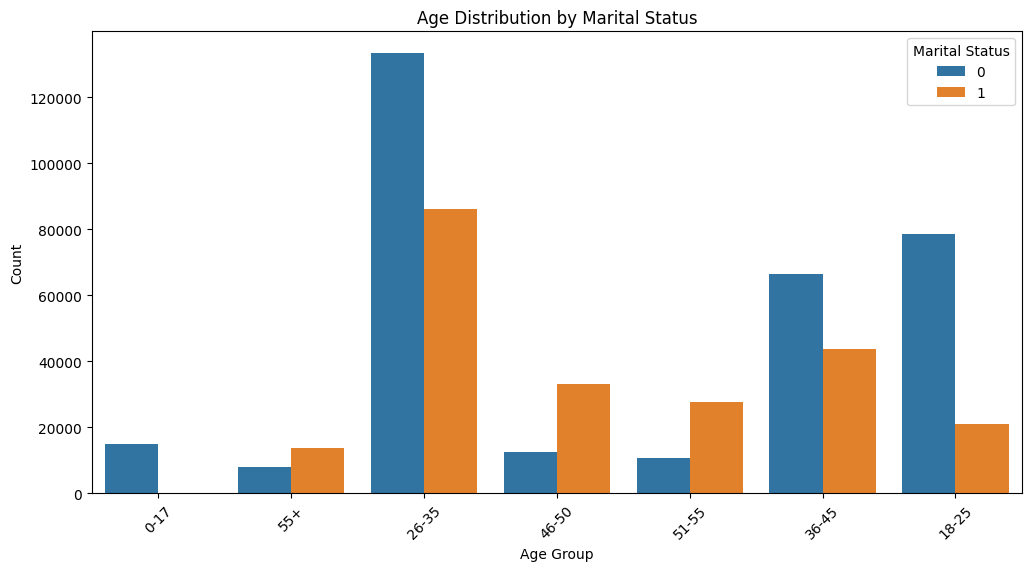

In [73]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Age', hue='Marital_Status', data=black_sale_data)
plt.title('Age Distribution by Marital Status')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Marital Status')
plt.show()

Por las distribuciones podemos asumir que `Marital_Status` es **0** para solteros (todos los menores de 17 años son de caterogría **0**, y la gran mayoría entre 18 y 25 años) y **1** para casados, a sabiendas que quedan otros posibles significados afuera.

Para entender un poco mejor las features de `Product_Category_N` vamos a ver un poco la distribución de precios de las ventas según estas variables. La idea es buscar una relación entre el hecho de tener un valor determinado en `Product_Category_1` y ese mismo valor en otra de las columnas:

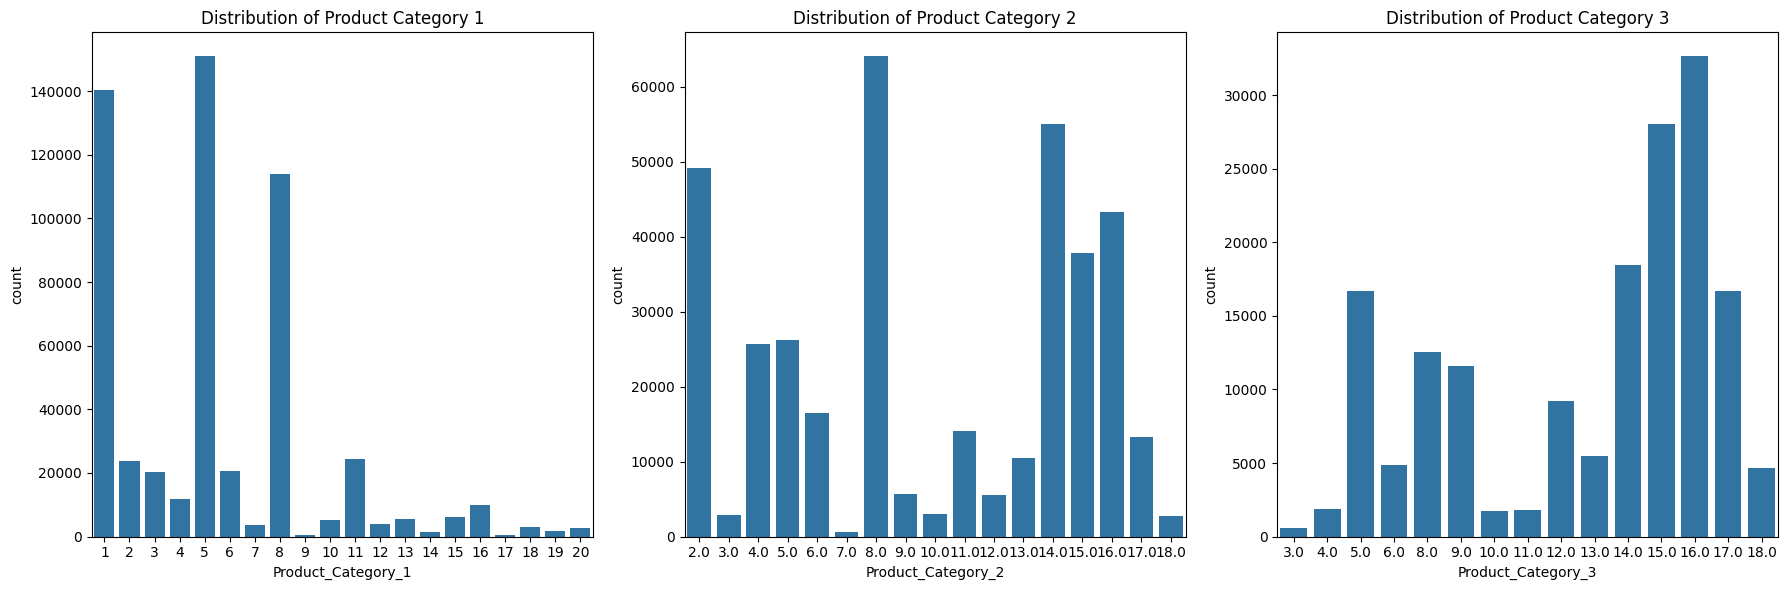

In [74]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.countplot(x='Product_Category_1', data=black_sale_data)
plt.title('Distribution of Product Category 1')

plt.subplot(1, 3, 2)
sns.countplot(x='Product_Category_2', data=black_sale_data)
plt.title('Distribution of Product Category 2')

plt.subplot(1, 3, 3)
sns.countplot(x='Product_Category_3', data=black_sale_data)
plt.title('Distribution of Product Category 3')

plt.tight_layout()
plt.show()

No queda del todo claro si se utilizan los mismos identificadores para las mismas categorías, que podrían ser en algunos casos la principal para un producto, y la secundaria o terciaria para otro. Conocer esto no es estrictamente necesario para procesar los datos y entrenar un modelo, pero serviría para explorar alternativas como la creación de features que indique que un producto ***tiene la categoría x en alguna de las columnas correspondientes***. Esto sería útil para reducir features, pero de este gráfico podemos ver, que al menos para algunos casos, podría tener mucho peso en el precio que el identificador de la categoría esté en la columna 1 o bien en la columna 2 o 3. Por tanto, no parece una buena idea utilizar una estrategia como esta, y parece que lo mejor es tratar cada feature de forma independiente.

Lo que si queremos explorar, a continuación, es si tenemos valores faltantes en las columnas `Product_Category_2` y `Product_Category_3`, o simplemente se trata de productos con una/dos categorías, y no tres que lo describan. Para eso, comparemos en todos los datos, si para mismo `Product_ID` tenemos los mismos valores en las 3 columnas, incluyendo los mismos faltantes.

In [75]:
duplicates = black_sale_data[black_sale_data.duplicated(subset=['Product_ID'], keep=False)]

# Agrupamos por product ID
product_category_variations = duplicates.groupby('Product_ID').agg({'Product_Category_1': 'nunique',
                                                                   'Product_Category_2': 'nunique',
                                                                   'Product_Category_3': 'nunique'})

# Filtramos por productos con cualquier variación en las columnas de Product_Category_N
products_with_variations = product_category_variations[
    (product_category_variations['Product_Category_1'] > 1) |
    (product_category_variations['Product_Category_2'] > 1) |
    (product_category_variations['Product_Category_3'] > 1)
]

print("Product IDs with different category combinations:")
print(products_with_variations.index.tolist())

Product IDs with different category combinations:
[]


Al no haber casos, y siendo que como vimos antes, siempre tienen al menos una categoría, vamos a suponer que los productos pueden tener una o dos categorías, y que el faltante es descriptivo del producto.

Veamos algunas distribuciones de las observaciones según algunas features, y a su vez, distribuciones del target `Purchase` según las mismas.

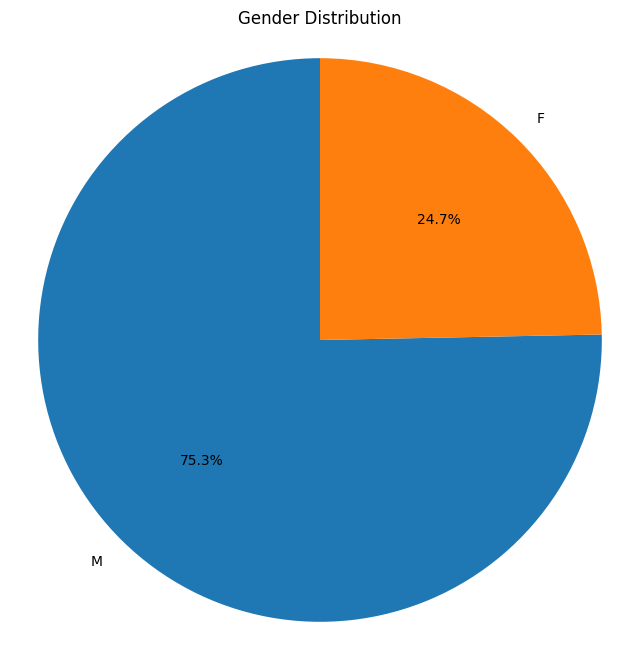

In [76]:
gender_counts = black_sale_data['Gender'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Gender Distribution')
plt.axis('equal')
plt.show()

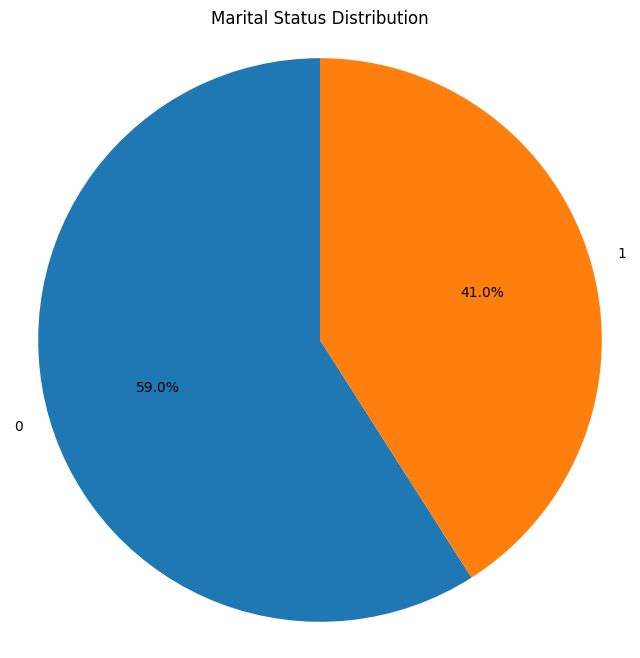

In [77]:
marital_status_counts = black_sale_data['Marital_Status'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(marital_status_counts, labels=marital_status_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Marital Status Distribution')
plt.axis('equal')
plt.show()

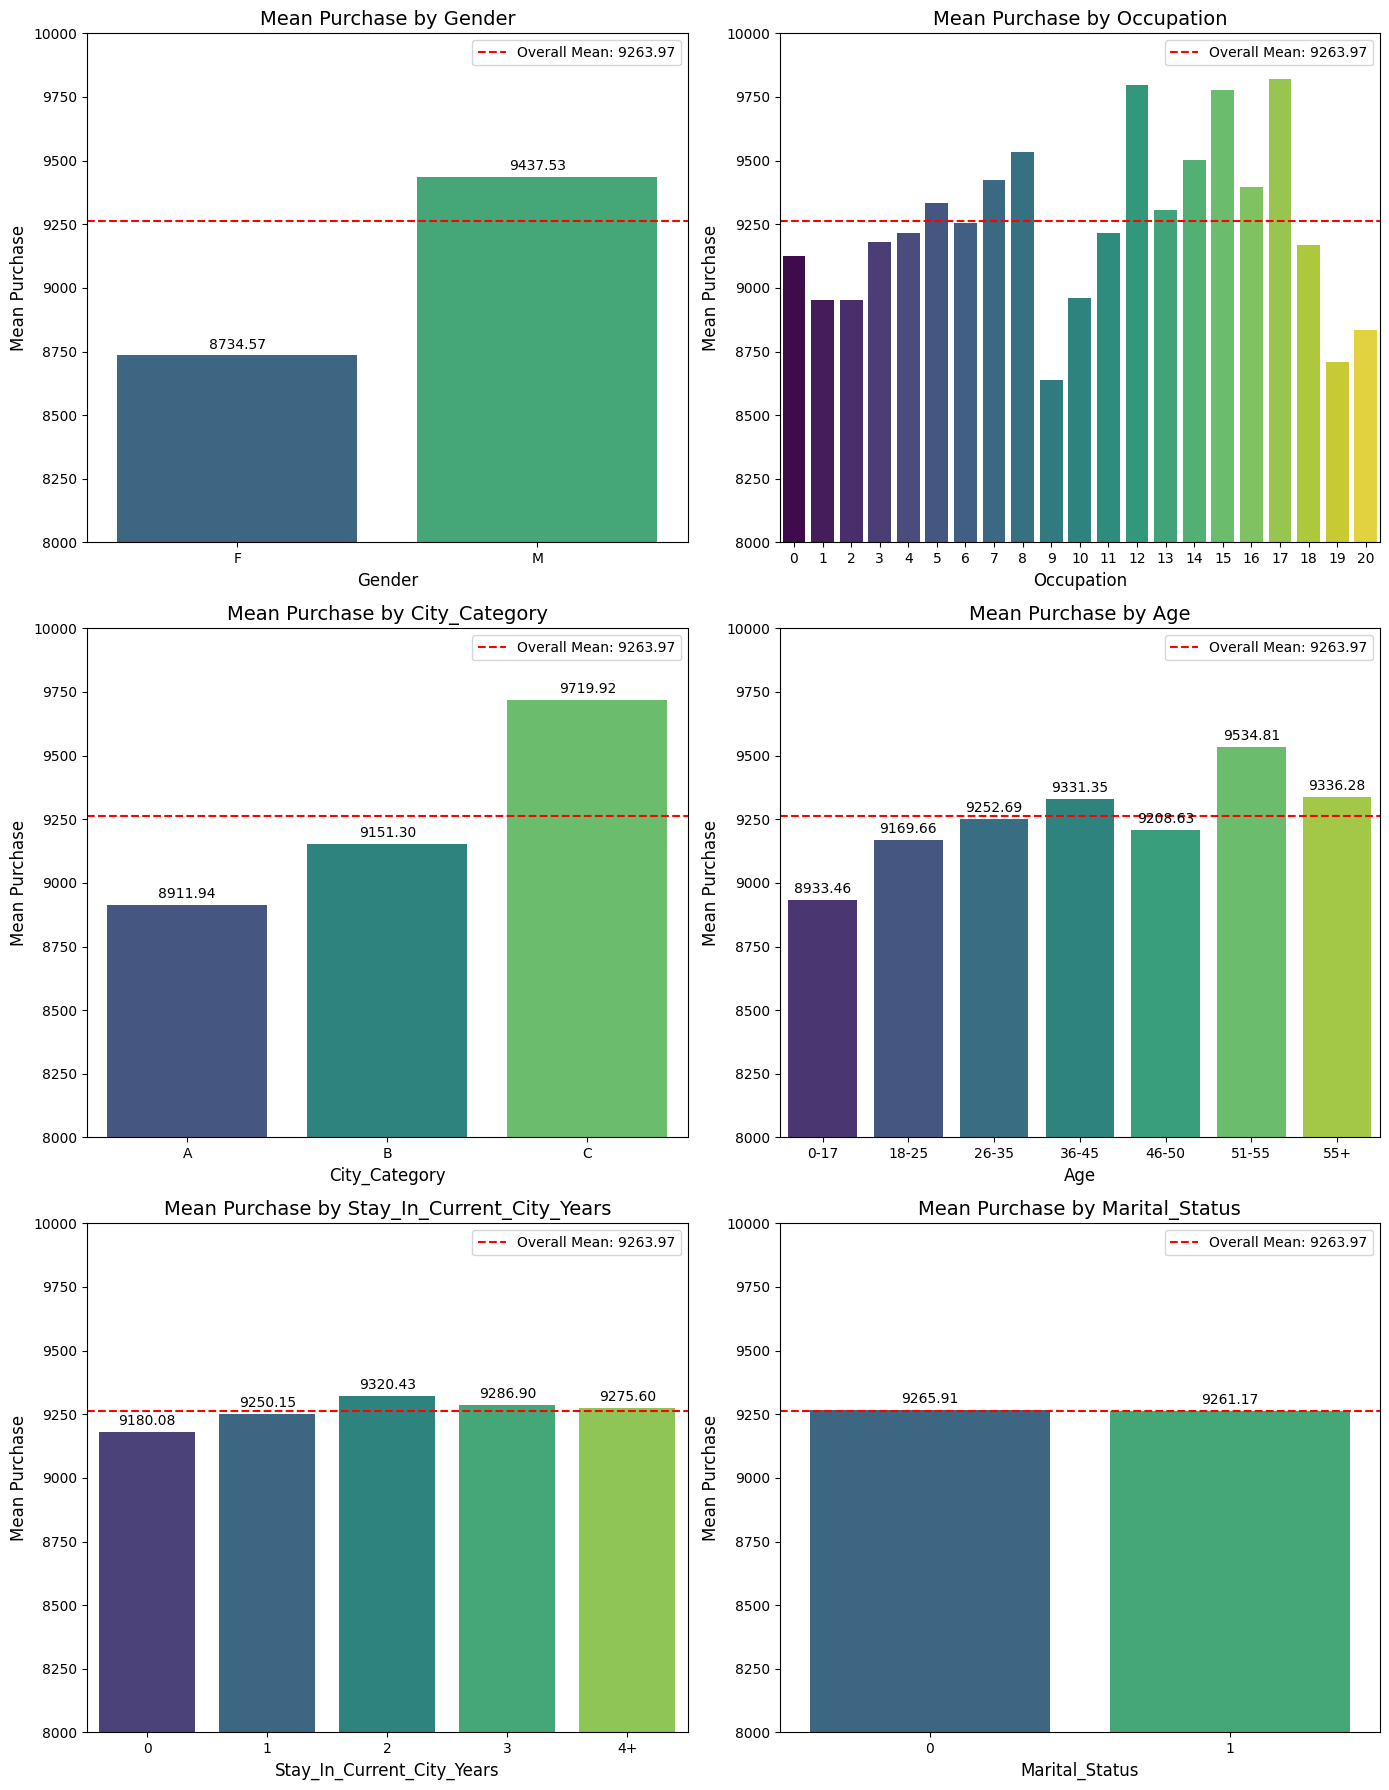

In [78]:
features = ['Gender', 'Occupation', 'City_Category', 'Age', 'Stay_In_Current_City_Years', 'Marital_Status']

fig, axes = plt.subplots(3, 2, figsize=(14, 18)) # Configurar 3 filas y 2 columnas
axes = axes.flatten()

overall_mean = black_sale_data['Purchase'].mean() # Media general de 'Purchase'

for i, feature in enumerate(features):
    ax = axes[i]

    # Calcular la media de compra por característica
    purchase_mean_by_feature = black_sale_data.groupby(feature)['Purchase'].mean()

    # Crear el gráfico de barras
    sns.barplot(
        x=purchase_mean_by_feature.index,
        y=purchase_mean_by_feature.values,
        ax=ax,
        palette="viridis",
        hue=purchase_mean_by_feature.index,
        dodge=False,
        legend=False
    )

    # Fijar rango del eje Y
    ax.set_ylim(8000, 10000)

    # Agregar línea de referencia para la media general
    ax.axhline(overall_mean, color='red', linestyle='--', label=f'Overall Mean: {overall_mean:.2f}')

    ax.set_title(f'Mean Purchase by {feature}', fontsize=14)
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel('Mean Purchase', fontsize=12)

    # Agregar etiquetas de valores en las barras
    if (feature != 'Occupation'):
      for p in ax.patches:
          ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

    ax.legend()

plt.tight_layout()
plt.show()

Información que podemos extraer de estos gráficos:
- Las compras realizadas por hombres tienen en promedio un valor superior al de las realizadas por mujeres.
- Perece haber una relación entre la categoría de la ciudad y el precio, dado que las compras en ciudades de categoría C son marcadamente superiores a B, y B superiores a su vez a A.
- No se observan diferencias el estado civil y el precio de la compra.
- Con la edad ocurre un crecimiento del valor de las compras, hasta el rango de 46-50, siendo luego el máximo alcanzado en 51-55 para volver a caer.

Finalmente, veamos la distribución de los valores de compra de los productos. Para ello, usemos bins de 1000, dado que los límites pedidos de los grupos están definidos en 5000, 10000 y 15000:

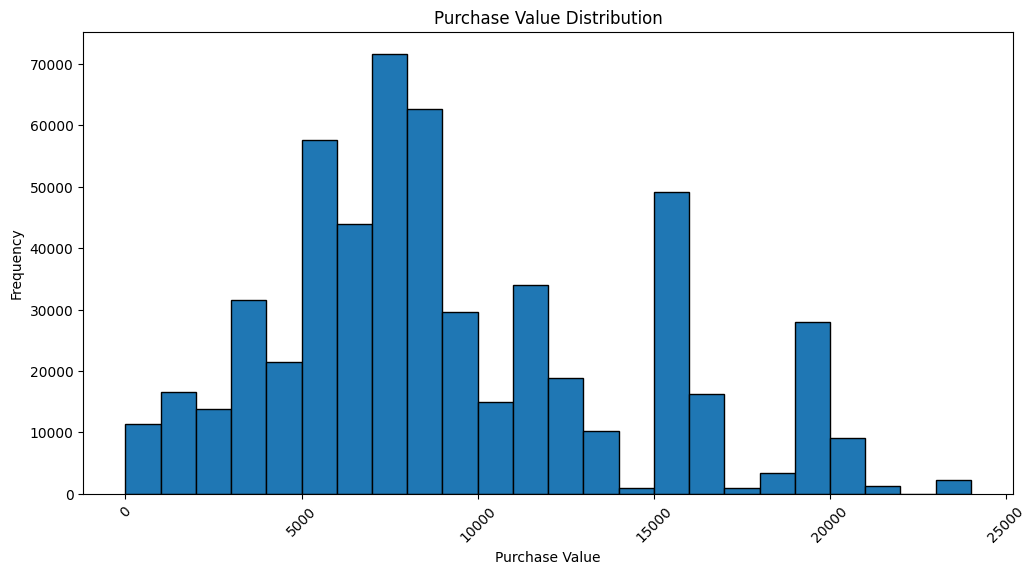

In [79]:
plt.figure(figsize=(12, 6))
plt.hist(black_sale_data['Purchase'], bins=range(0, int(black_sale_data['Purchase'].max()) + 1000, 1000), edgecolor='black')
plt.xlabel('Purchase Value')
plt.ylabel('Frequency')
plt.title('Purchase Value Distribution')
plt.xticks(rotation=45)
plt.show()



A este punto podemos identificar que los datos pueden ser problemáticos para la tarea solicitada, dados los picos en 5000, 1000, 15000 (valores que delimitan las categorías a predecir). En la distribución podemos ver que muchas observaciones están entre 5000 y 6000, y entre 9000 y 10000. Por otro lado, una situación aún más marcada tenemos justo por encima de los 15000.
Estas características del set de datos podrían complicar al modelo a predecir correctamente el grupo de comprador.

### Feature Engineering ###

Procedemos con el procesamiento de nuestras features:
- Completar las missing de `Product_Category_2`, `Product_Category_3` con -1 (dado que se identificó que no es una cuestión de error en carga de datos)
- Aplicamos One hot encoding en las categorías no ordinales con las que contamos: `Product_Category_1`, `Product_Category_2`, `Product_Category_3`, `Occupation`, `Gender`, `Marital_Status`.
- Convertimos las categorías de `Age` a enteros, entendiendo que hay un orden (aunque no haya una correlación lineal con el precio de la compra).
- Convertimos `Stay_In_Current_City_Years` a entero (el caso faltante 4+).
- Convertimos `City_Category` a entero, entendiendo que hay un orden implícito en la categoría.

In [101]:
black_sale_data_processed = black_sale_data.copy()

In [102]:
for col in ['Product_Category_1', 'Product_Category_2', 'Product_Category_3', 'Occupation']:
    black_sale_data_processed[col] = black_sale_data_processed[col].fillna(-1).astype(int)

In [103]:
age_map = {
    '0-17': 0,
    '18-25': 1,
    '26-35': 2,
    '36-45': 3,
    '46-50': 4,
    '51-55': 5,
    '55+': 6
}
black_sale_data_processed['Age'] = black_sale_data_processed['Age'].map(age_map)

In [104]:
city_category_mapping = {'A': 3, 'B': 2, 'C': 1}
black_sale_data_processed['City_Category'] = black_sale_data_processed['City_Category'].map(city_category_mapping)

In [105]:
black_sale_data_processed['Stay_In_Current_City_Years'] = black_sale_data_processed['Stay_In_Current_City_Years'].replace('4+', 4).astype(int)

In [106]:
black_sale_data_processed['Marital_Status'] = black_sale_data_processed['Marital_Status'].map({0: 'Single', 1: 'Married'})

In [107]:
black_sale_data_processed = pd.get_dummies(black_sale_data_processed, columns=['Gender', 'Marital_Status', 'Occupation'], drop_first=True)

In [87]:
# Create a copy of the original DataFrame for adding extra columns
black_sale_data_processed_with_extra_columns = black_sale_data_processed.copy()

# Identify all unique product categories from Product_Category_1, 2, and 3
unique_categories = set(black_sale_data_processed_with_extra_columns[['Product_Category_1', 'Product_Category_2', 'Product_Category_3']].stack())

# Iterate through each unique category and create a new column
for category in unique_categories:
    black_sale_data_processed_with_extra_columns[f'Has_Product_Category_{category}'] = (
        (black_sale_data_processed_with_extra_columns['Product_Category_1'] == category) |
        (black_sale_data_processed_with_extra_columns['Product_Category_2'] == category) |
        (black_sale_data_processed_with_extra_columns['Product_Category_3'] == category)
    ).astype(int)
black_sale_data_processed_with_extra_columns = black_sale_data_processed_with_extra_columns.drop(columns=['Has_Product_Category_-1'])

In [108]:
black_sale_data_processed = pd.get_dummies(black_sale_data_processed, columns=['Product_Category_1', 'Product_Category_2', 'Product_Category_3'], drop_first=True)


In [109]:
black_sale_data_processed

User_ID Product_ID  Age  City_Category  Stay_In_Current_City_Years  \
0       1000001  P00069042    0              3                           2   
1       1000001  P00248942    0              3                           2   
2       1000001  P00087842    0              3                           2   
3       1000001  P00085442    0              3                           2   
4       1000002  P00285442    6              1                           4   
...         ...        ...  ...            ...                         ...   
550063  1006033  P00372445    5              2                           1   
550064  1006035  P00375436    2              1                           3   
550065  1006036  P00375436    2              2                           4   
550066  1006038  P00375436    6              1                           2   
550067  1006039  P00371644    4              2                           4   

        Purchase  Gender_M  Marital_Status_Single  Occupation_1  Occupation_2  \
0           8370     False                   True         False         False   
1          15200     False                   True         False         False   
2           1422     False                   True         False         False   
3           1057     False                   True         False         False   
4           7969      True                   True         False         False   
...          ...       ...                    ...           ...           ...   
550063       368      True                  False         False         False   
550064       371     False                   True          True         False   
550065       137     False                  False         False         False   
550066       365     False                   True          True         False   
550067       490     False                  False         False         False   

        ...  Product_Category_3_9  Product_Category_3_10  \
0       ...                 False                  False   
1       ...                 False                  False   
2       ...                 False                  False   
3       ...                 False                  False   
4       ...                 False                  False   
...     ...                   ...                    ...   
550063  ...                 False                  False   
550064  ...                 False                  False   
550065  ...                 False                  False   
550066  ...                 False                  False   
550067  ...                 False                  False   

        Product_Category_3_11  Product_Category_3_12  Product_Category_3_13  \
0                       False                  False                  False   
1                       False                  False                  False   
2                       False                  False                  False   
3                       False                  False                  False   
4                       False                  False                  False   
...                       ...                    ...                    ...   
550063                  False                  False                  False   
550064                  False                  False                  False   
550065                  False                  False                  False   
550066                  False                  False                  False   
550067                  False                  False                  False   

        Product_Category_3_14  Product_Category_3_15  Product_Category_3_16  \
0                       False                  False                  False   
1                        True                  False                  False   
2                       False                  False                  False   
3                       False                  False                  False   
4                       False    

In [110]:
bins = [0, 5000, 10000, 15000, float('inf')] # Límites de los rangos
labels = [0, 1, 2, 3] # Grupos correspondientes
black_sale_data_processed['Purchase_Group'] = pd.cut(
    black_sale_data_processed['Purchase'],
    bins=bins,
    labels=labels,
    right=False # Excluye el límite superior del rango
)

In [111]:
black_sale_data_processed['Purchase_Group'] = pd.to_numeric(black_sale_data_processed['Purchase_Group'], errors='coerce')
purchase_group_counts = black_sale_data_processed['Purchase_Group'].value_counts().sort_index()
print(purchase_group_counts)

Purchase_Group
0     94923
1    265606
2     79016
3    110523
Name: count, dtype: int64


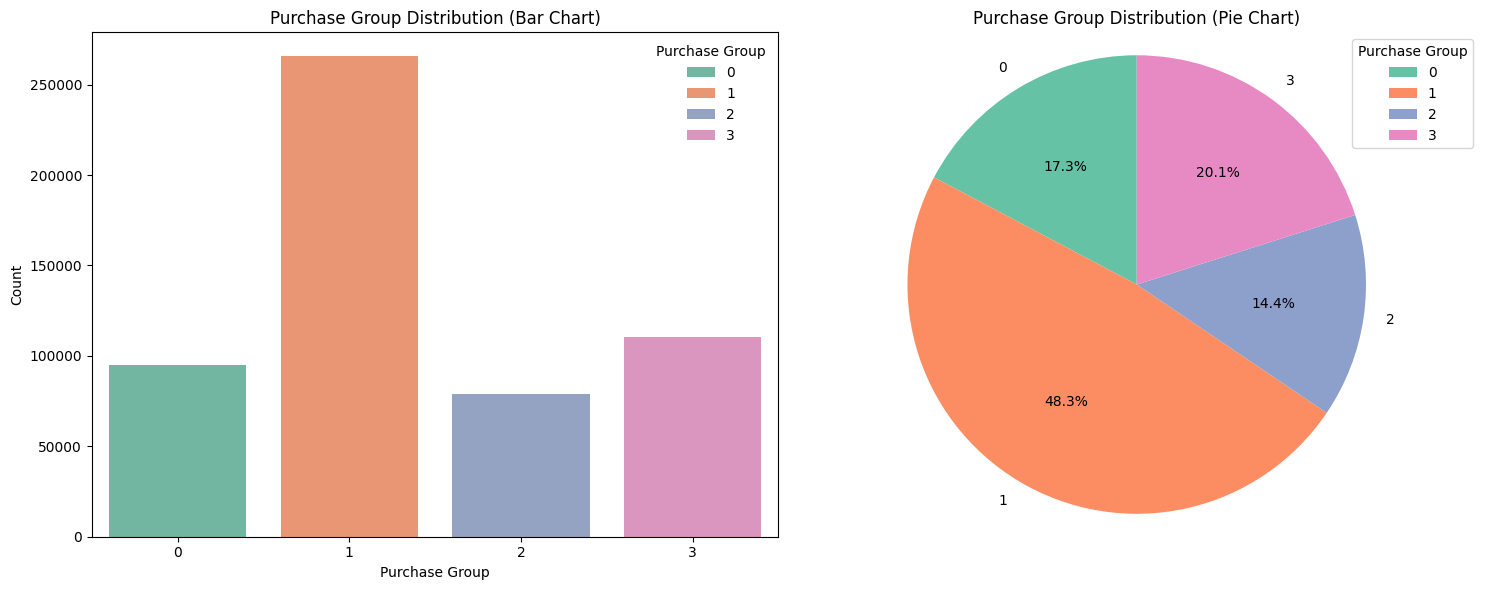

In [92]:
purchase_group_counts = black_sale_data_processed['Purchase_Group'].value_counts()
purchase_group_counts = purchase_group_counts.sort_index()

fixed_colors = sns.color_palette("Set2", len(purchase_group_counts))

color_dict = {str(group): color for group, color in zip(purchase_group_counts.index, fixed_colors)}

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.barplot(x=purchase_group_counts.index, y=purchase_group_counts.values, ax=axes[0], hue=purchase_group_counts.index, palette=bar_colors)
axes[0].set_title('Purchase Group Distribution (Bar Chart)')
axes[0].set_xlabel('Purchase Group')
axes[0].set_ylabel('Count')
axes[0].legend(title='Purchase Group', loc='best', frameon=False)

axes[1].pie(purchase_group_counts, labels=purchase_group_counts.index.astype(str), autopct='%1.1f%%', startangle=90, colors=fixed_colors)
axes[1].set_title('Purchase Group Distribution (Pie Chart)')
axes[1].axis('equal')
axes[1].legend(purchase_group_counts.index.astype(str), title='Purchase Group', loc='best')

plt.tight_layout()
plt.show()

Podemos observar que los grupos de compradores nos quedan desbalanceados, siendo con diferencia (casi un 50%) compradores de categoría 1, seguidos de compradores de categoría 3 con un 20,1%.

Para tener un primer benchmark antes de entrenar cualquier modelo, podríamos decir que la heurística más básica que eligiese siempre la categoría más popular, acertaría con una precisión del 48,3%,


Además, viendo la distribución de `Purchase` original, habiamos mencionado que muchas observaciones estaban cerca de su grupo vecino. Plasmemos eso en números, identificando cuantas observaciones están a menos de 500 unidades del grupo vecino más cercano. Esto corresponde a un 10% del valor del rango:

In [93]:
tolerance = 500

# Crear una función para verificar si una observación está dentro de 500 unidades del límite
def count_near_boundaries(row, bins, tolerance):
    for i in range(1, len(bins)):
        # Verificar si la observación está cerca del límite superior o inferior de un bin
        if abs(row - bins[i-1]) < tolerance or abs(row - bins[i]) < tolerance:
            return True
    return False

# Aplicar la función a las observaciones
black_sale_data_processed['Near_Boundary'] = black_sale_data_processed['Purchase'].apply(
    lambda x: count_near_boundaries(x, bins, tolerance)
)

# Contar el número de observaciones cerca de los límites (Near_Boundary == True)
near_boundary_count = black_sale_data_processed['Near_Boundary'].sum()

# Calcular el porcentaje de observaciones cerca de los límites
total_count = len(black_sale_data_processed)
near_boundary_percentage = (near_boundary_count / total_count) * 100

print(f"Porcentaje de observaciones cerca de los límites: {near_boundary_percentage:.2f}%")

Porcentaje de observaciones cerca de los límites: 20.27%


Con esto confirmamos un poco lo expuesto. 1 de cada 5 observaciones están cerca de su grupo vecino más próximo.

Finalmente, confirmamos que no quedaron valores faltantes en ninguna columna:

In [112]:
for col in black_sale_data_processed.columns:
  print(f"Column '{col}': Number of NaN values - {black_sale_data_processed[col].isna().sum()}")

Column 'User_ID': Number of NaN values - 0
Column 'Product_ID': Number of NaN values - 0
Column 'Age': Number of NaN values - 0
Column 'City_Category': Number of NaN values - 0
Column 'Stay_In_Current_City_Years': Number of NaN values - 0
Column 'Purchase': Number of NaN values - 0
Column 'Gender_M': Number of NaN values - 0
Column 'Marital_Status_Single': Number of NaN values - 0
Column 'Occupation_1': Number of NaN values - 0
Column 'Occupation_2': Number of NaN values - 0
Column 'Occupation_3': Number of NaN values - 0
Column 'Occupation_4': Number of NaN values - 0
Column 'Occupation_5': Number of NaN values - 0
Column 'Occupation_6': Number of NaN values - 0
Column 'Occupation_7': Number of NaN values - 0
Column 'Occupation_8': Number of NaN values - 0
Column 'Occupation_9': Number of NaN values - 0
Column 'Occupation_10': Number of NaN values - 0
Column 'Occupation_11': Number of NaN values - 0
Column 'Occupation_12': Number of NaN values - 0
Column 'Occupation_13': Number of NaN

## Entrenamiento de modelos básicos (b)

Ya mencinamos como primer benchmark la utilización del grupo con más ocurrencias como predicción. Esto resultaría con un 48,3% de precisión.

A continuación entrenemos 3 modelos: una regresión logística, un random forest y cat boost, para encontrar nuevas métricas. En todos los casos, obtendremos los valores de precisión y precisión balanceada.

In [113]:
X = black_sale_data_processed.drop(columns=['Purchase', 'Purchase_Group', 'User_ID', 'Product_ID'])
y = black_sale_data_processed['Purchase_Group']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [114]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [134]:
def evaluate_classifier(classifier, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    print(f"Balanced Accuracy: {balanced_accuracy:.4f}")

    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    if hasattr(classifier, "predict_proba"):
        y_prob = classifier.predict_proba(X_test_scaled)
        auc_score = roc_auc_score(y_test, y_prob, multi_class='ovr')
        print(f"AUC Score: {auc_score:.4f}")

    conf_matrix = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

In [124]:
logistic_regression_classifier = LogisticRegression(max_iter=1000, random_state=42)
logistic_regression_classifier.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42)

Accuracy: 0.7128
Balanced Accuracy: 0.626663965103551
Precision: 0.7252
Recall: 0.7128
F1-Score: 0.6938

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.45      0.58     18985
           1       0.82      0.84      0.83     53121
           2       0.53      0.27      0.35     15803
           3       0.57      0.95      0.71     22105

    accuracy                           0.71    110014
   macro avg       0.68      0.63      0.62    110014
weighted avg       0.73      0.71      0.69    110014

AUC Score: 0.8667


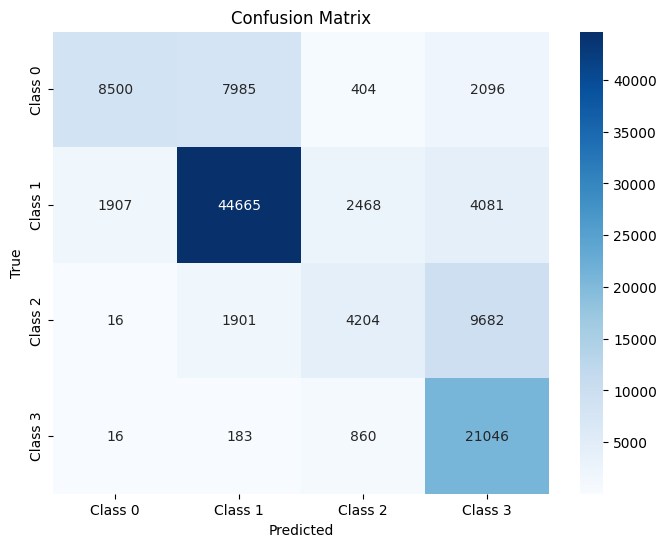

In [125]:
y_pred_logistic = logistic_regression_classifier.predict(X_test_scaled)
evaluate_classifier(logistic_regression_classifier, y_pred_logistic)

Con este primer modelo conseguimos un accuracy del 71,26% pero un balanced accuracy de tan solo el 62,66%, lo cual confirma la complicación del modelo de predecir las clases minoritarias. Veamoslo en una matriz de confusión.

In [122]:
random_forest_classifier = RandomForestClassifier(random_state=42)
random_forest_classifier.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

Accuracy: 0.6935
Balanced Accuracy: 0.6054
Precision: 0.6886
Recall: 0.6935
F1-Score: 0.6832

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.46      0.56     18985
           1       0.78      0.85      0.82     53121
           2       0.43      0.36      0.39     15803
           3       0.62      0.75      0.68     22105

    accuracy                           0.69    110014
   macro avg       0.64      0.61      0.61    110014
weighted avg       0.69      0.69      0.68    110014

AUC Score: 0.8584


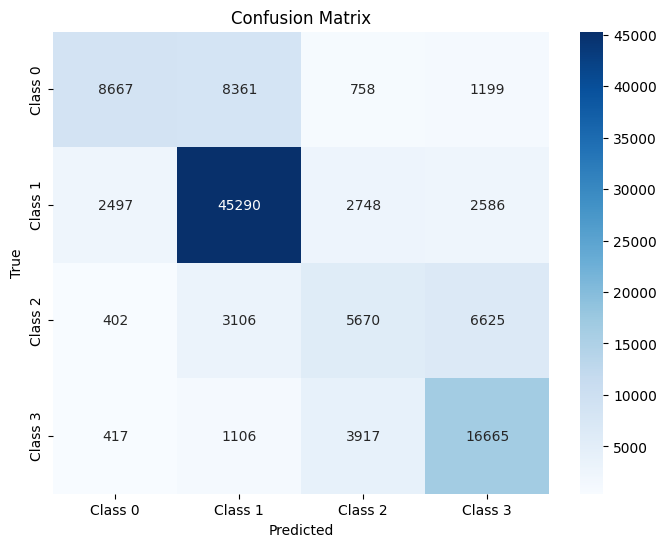

In [136]:
y_pred_random_forest = random_forest_classifier.predict(X_test_scaled)
evaluate_classifier(random_forest_classifier, y_pred_random_forest)

In [132]:
catboost_classifier = CatBoostClassifier(random_state=42, verbose=0)
catboost_classifier.fit(X_train_scaled, y_train)

Accuracy: 0.7177
Balanced Accuracy: 0.6314
Precision: 0.7270
Recall: 0.7177
F1-Score: 0.6997

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.44      0.58     18985
           1       0.81      0.85      0.83     53121
           2       0.52      0.29      0.37     15803
           3       0.59      0.94      0.72     22105

    accuracy                           0.72    110014
   macro avg       0.69      0.63      0.63    110014
weighted avg       0.73      0.72      0.70    110014

AUC Score: 0.8799


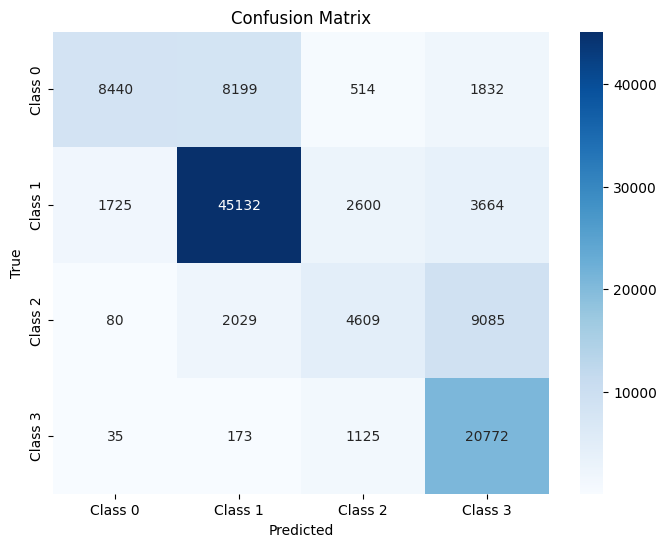

In [137]:
y_pred_catboost = catboost_classifier.predict(X_test_scaled)
evaluate_classifier(catboost_classifier, y_pred_catboost)

Con CatBoost presentamos los mejores resultados, apenas por encima de los otros dos modelos.
Teniendo en consideración que no hicimos búsqueda de hiperparámetros, estos modelos al menos nos dan una buena base para empezar a trabajar con una red neuronal. La precisión balanceada a buscar debería ser superir a 63,14%


Por otra parte, amerita mencionar el problema que intuímos ibamos a tener por los datos y los rangos de precios de los grupos solicitados. Vemos que ambos modelos predicen muchos casos de Clase 0 como Clase 1 y Clase 2 como Clase 3. Los que mejor funcionan son las prediciones de Clase 1 y 3, dado que son las que más observaciones presentan. Este comportamiento está relacionado con la distribución analizada, con muchas observaciones cerca de los límites de los grupos definidos, que complican al modelo para diferenciar correctamente la clase.

## Entrenamiento de Red Neuronal sin embedding (c) ##

In [138]:
X_numpy = X.to_numpy(dtype='float')
y_numpy = y.to_numpy(dtype='float')

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X_numpy, y_numpy, test_size=0.2, random_state=42, stratify=y)

In [140]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [141]:
class BlackSaleDataset(Dataset):

  #__init__ guarda el dataset en una variable de clase
  def __init__(self, x, y):
    self.x = torch.tensor(x, dtype=torch.float32)
    self.y = torch.tensor(y, dtype=torch.long)

  # __len__ define el comportamiento de la función len() sobre el objeto
  def __len__(self):
    return len(self.x)

  # __getitem__ define el comportamiento de los []
  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

In [142]:
X_train_scaled.shape

(440054, 76)

In [143]:
y_train.shape

(440054,)

In [144]:
train_black_sale_ds = BlackSaleDataset(X_train_scaled, y_train)

In [145]:
X_train_scaled.shape

(440054, 76)

In [147]:
test_black_sale_ds = BlackSaleDataset(X_test_scaled, y_test)

In [148]:
train_dataloader = DataLoader(train_black_sale_ds, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_black_sale_ds, batch_size=64)

In [153]:
class NNet(torch.nn.Module):

  def __init__(self, input_size, output_size):
    # Defino la arquitectura de la red
    super().__init__()
    self.linear_1 = torch.nn.Linear(in_features=input_size, out_features=128, bias=True)
    self.relu_1 = torch.nn.ReLU()
    self.linear_2 = torch.nn.Linear(in_features=128, out_features=64, bias=True)
    self.relu_2 = torch.nn.ReLU()
    self.linear_3 = torch.nn.Linear(in_features=64, out_features=32, bias=True)
    self.relu_3 = torch.nn.ReLU()
    self.linear_4 = torch.nn.Linear(in_features=32, out_features=output_size, bias=True)

  def forward(self, x):
    # Defino el cálculo del paso forward
    x = self.linear_1(x)
    x = self.relu_1(x)
    x = self.linear_2(x)
    x = self.relu_2(x)
    x = self.linear_3(x)
    x = self.relu_3(x)
    x = self.linear_4(x)
    return x

In [163]:
print(X_train.shape[1])
input_size = X_train.shape[1] # Número de características de entrada
output_size = len(np.unique(y_train)) # Número de clases (4 grupos en este caso)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Crear el modelo
nnet = NNet(input_size, output_size).to(device)

# Configurar el optimizador y la función de pérdida
optimizer = optim.Adam(nnet.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

76


In [162]:
# cantidad de epochs
epochs = 20

train_loss_by_epoch=[]
valid_loss_by_epoch=[]

n_train = X_train_scaled.shape[0]
n_valid = X_test_scaled.shape[0]
print(len(train_dataloader))
print(len(test_dataloader))

# Doble loop algoritmo Mini-Batch
for epoch in range(epochs):

  ############################################
  ## Entrenamiento
  ############################################
  nnet.train()

  epoch_loss = 0
  epoch_y_hat = []
  epoch_y = []

  for i, data in enumerate(train_dataloader):
    # Obtengo los datos del batch de entrenamiento
    x_batch, y_batch = data

    # Copio el batch al dispositivo donde entreno la red neuronal
    x_batch = x_batch.to(device).float()
    y_batch = y_batch.to(device).long()

    # Paso forward
    # Limpio optimizer para empezar un nuevo cálculo de gradiente
    optimizer.zero_grad()
    nnet_output = nnet(x_batch)
    _, y_batch_hat = torch.max(nnet_output, dim=1)

    # Calculo el loss
    loss = criterion(nnet_output, y_batch)

    # Backpropagation
    loss.backward()

    # Actualizar los parámetros
    optimizer.step()

    # Almaceno los valores reales y mis predicciones para cálcular las métricas
    epoch_y.extend(y_batch.cpu().numpy())
    epoch_y_hat.extend(y_batch_hat.cpu().numpy())
    # Acumulo la loss del batch
    epoch_loss = epoch_loss + loss.item()

  # Calculo la media de la loss
  epoch_loss = epoch_loss / len(train_dataloader)
  # Almaceno la loss de la epoch para graficar
  train_loss_by_epoch.append(epoch_loss)
  # Cálculo la métrica de la epoch
  balanced_accuracy = balanced_accuracy_score(epoch_y, epoch_y_hat)

  ############################################
  ## Validación
  ############################################
  # Desactivo el cálculo de gradiente para validación
  nnet.eval()

  valid_epoch_loss = 0
  valid_epoch_y_hat = []
  valid_epoch_y = []

  for i,data in enumerate(test_dataloader):
    # Obtengo los datos del batch de validación
    x_batch, y_batch = data
    # Copio el batch al dispositivo donde entreno la red neuronal
    x_batch = x_batch.to(device).float()
    y_batch = y_batch.to(device).long()

    # Paso forward
    nnet_output = nnet(x_batch)
    _, y_batch_hat = torch.max(nnet_output, dim=1)

    # Calculo el loss
    loss = criterion(nnet_output, y_batch)

    # En validación no hago backpropagation!!

    # Almaceno los valores reales y mis predicciones para cálcular las métricas
    valid_epoch_y.extend(y_batch.cpu().numpy())
    valid_epoch_y_hat.extend(y_batch_hat.cpu().numpy())
    # Acumulo la loss del batch
    valid_epoch_loss = valid_epoch_loss + loss.item()

  # Calculo la media de la loss
  valid_epoch_loss = valid_epoch_loss / len(test_dataloader)
  # Almaceno la loss de la epoch para graficar
  valid_loss_by_epoch.append(valid_epoch_loss)
  # Cálculo la métrica de la epoch
  valid_balanced_accuracy = balanced_accuracy_score(valid_epoch_y, valid_epoch_y_hat)

  ############################################
  ## Impresión de resultados por epoch
  ############################################
  print(f" Epoch {epoch} | " \
        f"Train/Valid loss: {epoch_loss:.3f} / {valid_epoch_loss:.3f} | " \
        f"Train/Valid accuracy: {balanced_accuracy:.3f} / {valid_balanced_accuracy:.3f}")

[1, 3, 3, 1, 1, 1, 3, 3, 1, 3, 3, 1, 1, 3, 1, 3, 1, 1, 2, 3, 1, 1, 2, 1, 3, 2, 1, 2, 3, 2, 2, 3, 3, 1, 3, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 3, 3, 3, 1, 2, 2, 2, 3, 1, 3, 3, 0, 1, 1, 1, 1, 2, 2, 2, 1, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 3, 1, 0, 1, 1, 3, 2, 3, 1, 0, 1, 3, 1, 3, 1, 2, 3, 1, 1, 1, 1, 1, 3, 2, 3, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 3, 3, 1, 3, 2, 1, 1, 1, 3, 2, 1, 3, 1, 1, 2, 2, 1, 3, 1, 3, 3, 1, 1, 3, 1, 1, 1, 3, 3, 2, 1, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 1, 3, 0, 0, 1, 1, 1, 3, 3, 1, 1, 3, 1, 1, 1, 1, 3, 1, 3, 1, 3, 3, 3, 3, 1, 1, 3, 1, 1, 3, 1, 3, 3, 1, 3, 2, 1, 1, 3, 1, 3, 1, 1, 3, 1, 3, 3, 1, 1, 2, 1, 1, 2, 3, 1, 3, 3, 1, 1, 3, 0, 1, 1, 1, 1, 0, 3, 1, 3, 3, 1, 1, 2, 2, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1, 3, 1, 0, 3, 1, 1, 1, 3, 1, 3, 1, 0, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 2, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 1, 0, 1, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 3, 

Text(0, 0.5, 'BCE')

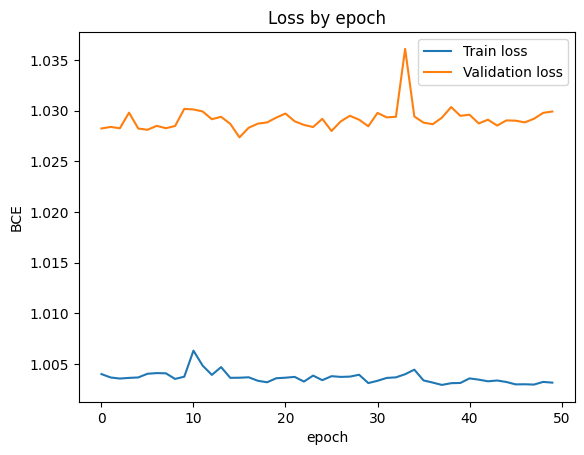

In [55]:
fig, ax1= plt.subplots(1,1)
ax1.plot(train_loss_by_epoch, label="Train loss")
ax1.plot(valid_loss_by_epoch, label="Validation loss")
ax1.legend()
ax1.set_title("Loss by epoch")
ax1.set_xlabel("epoch")
ax1.set_ylabel("BCE")

In [1]:
# cantidad de epochs
epochs = 1

train_loss_by_epoch=[]
valid_loss_by_epoch=[]

n_train = X_train_scaled.shape[0]
n_valid = X_test_scaled.shape[0]

# Doble loop algoritmo Mini-Batch
for epoch in range(epochs):

  ############################################
  ## Entrenamiento
  ############################################
  nnet.train(True)

  epoch_loss = 0
  epoch_y_hat = []
  epoch_y = []

  for i, data in enumerate(train_dataloader):
    # Obtengo los datos del batch de entrenamiento
    x_batch, y_batch = data

    # Copio el batch al dispositivo donde entreno la red neuronal
    x_batch = x_batch.to(device).float()
    y_batch = y_batch.to(device).float().reshape(-1, 1)
    y_batch = torch.squeeze(y_batch, dim=1)  # Reduce la dimensión extra
    y_batch = y_batch.long()  # Convertir a enteros

    # Paso forward
    # Limpio optimizer para empezar un nuevo cálculo de gradiente
    optimizer.zero_grad()
    nnet_output = nnet(x_batch)
    print(f"y_batch: {y_batch}")
    print(nnet_output)
    _, y_batch_hat = torch.max(nnet_output, dim=1) # Get class with highest probability
    print(y_batch_hat)

    # Calculo el loss
    loss = criterion(nnet_output, y_batch)

    # Backpropagation
    loss.backward()

    # Actualizar los parámetros
    optimizer.step()

    # Almaceno los valores reales y mis predicciones para cálcular las métricas
    epoch_y += list(y_batch.detach().cpu().numpy())
    epoch_y_hat += list(y_batch_hat.detach().cpu().numpy())
    # Acumulo la loss del batch
    epoch_loss = epoch_loss + loss.item()

  # Calculo la media de la loss
  epoch_loss = epoch_loss / len(train_dataloader)
  # Almaceno la loss de la epoch para graficar
  train_loss_by_epoch.append(epoch_loss)
  # Cálculo la métrica de la epoch
  accuracy = accuracy_score(epoch_y, epoch_y_hat) # Now both lists contain class labels

  ############################################
  ## Validación
  ############################################
  # Desactivo el cálculo de gradiente para validación
  nnet.train(False)

  valid_epoch_loss = 0
  valid_epoch_y_hat = []
  valid_epoch_y = []

  for i,data in enumerate(test_dataloader):
    # Obtengo los datos del batch de validación
    x_batch, y_batch = data
    # Copio el batch al dispositivo donde entreno la red neuronal
    x_batch = x_batch.to(device).float()
    y_batch = y_batch.to(device).float().reshape(-1, 1)
    y_batch = torch.squeeze(y_batch, dim=1)  # Reduce la dimensión extra
    y_batch = y_batch.long()  # Convertir a enteros

    # Paso forward
    nnet_output = nnet(x_batch)
    _, y_batch_hat = torch.max(nnet_output, dim=1) # Get class with highest probability

    # Calculo el loss
    loss = criterion(nnet_output, y_batch)

    # En validación no hago backpropagation!!

    # Almaceno los valores reales y mis predicciones para cálcular las métricas
    valid_epoch_y += list(y_batch.detach().cpu().numpy())
    valid_epoch_y_hat += list(y_batch_hat.detach().cpu().numpy())
    # Acumulo la loss del batch
    valid_epoch_loss = valid_epoch_loss + loss.item()

  # Calculo la media de la loss
  valid_epoch_loss = valid_epoch_loss / len(test_dataloader)
  # Almaceno la loss de la epoch para graficar
  valid_loss_by_epoch.append(valid_epoch_loss)
  # Cálculo la métrica de la epoch
  valid_accuracy = accuracy_score(valid_epoch_y, valid_epoch_y_hat)

  ############################################
  ## Impresión de resultados por epoch
  ############################################
  print(f" Epoch {epoch} | " \
        f"Train/Valid loss: {epoch_loss:.3f} / {valid_epoch_loss:.3f} | " \
        f"Train/Valid accuracy: {accuracy:.3f} / {valid_accuracy:.3f}")

NameError: name 'X_train_scaled' is not defined

In [55]:
# Convertir los datos a tensores de PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32) # Removed .values since X_train is already a numpy array
X_test_tensor = torch.tensor(X_test, dtype=torch.float32) # Removed .values since X_test is already a numpy array
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # Asegúrate de que y_train esté en formato long para clasificación, Removed .values since y_train is already a numpy array
y_test_tensor = torch.tensor(y_test, dtype=torch.long) # Removed .values since y_test is already a numpy array

# Crear datasets de PyTorch para entrenar y testear
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Crear DataLoader para manejar lotes de datos
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [56]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        # Capa de entrada (input layer)
        self.fc1 = nn.Linear(input_size, 64)  # 64 unidades en la capa oculta
        self.relu = nn.ReLU()  # Función de activación ReLU
        # Capa oculta
        self.fc2 = nn.Linear(64, 32)  # 32 unidades en la capa oculta
        # Capa de salida (output layer)
        self.fc3 = nn.Linear(32, output_size)  # 4 clases para clasificación multiclase
        self.softmax = nn.Softmax(dim=1)  # Softmax para clasificación multiclase
        self.dropout = nn.Dropout(0.5)  # Add dropout layer

    def forward(self, x):
        # Paso hacia adelante (forward pass)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)  # Apply dropout
        x = self.fc3(x)
        x = self.softmax(x)
        return x

In [57]:
input_size = X_train.shape[1]  # Número de características de entrada
output_size = 4  # Número de clases (en tu caso, 4 grupos de gasto)

# Create your model, optimizer, and scheduler:
nnet = Net(input_size, output_size)
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.01, weight_decay=0.001) # Add weight_decay
criterion = nn.NLLLoss()
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

# ... (Your training loop) ...

# In your training loop, after each epoch:


In [58]:
epochs = 50  # Número de épocas
for epoch in range(epochs):
    nnet.train()  # Establecer el modelo en modo de entrenamiento
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Limpiar los gradientes de la iteración anterior

        # Paso hacia adelante
        outputs = nnet(inputs)

        # Calcular la pérdida
        loss = criterion(outputs, labels)

        # Backpropagation y optimización
        loss.backward()
        optimizer.step()

        # Estadísticas de rendimiento
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    scheduler.step()
    # Calcular precisión y pérdida por época
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_predictions
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

Epoch [1/50], Loss: -0.5510, Accuracy: 0.5535
Epoch [2/50], Loss: -0.6650, Accuracy: 0.6724
Epoch [3/50], Loss: -0.6729, Accuracy: 0.6806
Epoch [4/50], Loss: -0.6734, Accuracy: 0.6812
Epoch [5/50], Loss: -0.6739, Accuracy: 0.6817
Epoch [6/50], Loss: -0.6739, Accuracy: 0.6815
Epoch [7/50], Loss: -0.6740, Accuracy: 0.6816
Epoch [8/50], Loss: -0.6742, Accuracy: 0.6818
Epoch [9/50], Loss: -0.6739, Accuracy: 0.6815
Epoch [10/50], Loss: -0.6740, Accuracy: 0.6816
Epoch [11/50], Loss: -0.6794, Accuracy: 0.6867
Epoch [12/50], Loss: -0.6866, Accuracy: 0.6936
Epoch [13/50], Loss: -0.6901, Accuracy: 0.6970
Epoch [14/50], Loss: -0.6904, Accuracy: 0.6970
Epoch [15/50], Loss: -0.6904, Accuracy: 0.6971
Epoch [16/50], Loss: -0.6905, Accuracy: 0.6970
Epoch [17/50], Loss: -0.6906, Accuracy: 0.6971
Epoch [18/50], Loss: -0.6906, Accuracy: 0.6972
Epoch [19/50], Loss: -0.6906, Accuracy: 0.6970
Epoch [20/50], Loss: -0.6907, Accuracy: 0.6972
Epoch [21/50], Loss: -0.6911, Accuracy: 0.6974
Epoch [22/50], Loss: -

KeyboardInterrupt: 

# Parte 2.a

Implemente una arquitectura de red neuronal basada en CNN para identificar del dataset fashion MNIST las 10 clases del mismo. Sobre dicho modelo, realize una exploración de 5 variantes distintas (que se desprenden del modelo propuesto) variando alguno (o varios) de los siguientes hiperparámetros:
- numero de capas.
- numero de kernels.
- tamaño de kernels.


Evalue la evolución de la función de perdida y la accuracy (para train y test) para cada modelo en una gráfica con las curvas de los 5 modelos propuestos. Compare también el tiempo de entrenamiento y peso (tamaño) de cada modelo. Aplique técnicas de regularización para evitar overfitting. Elija el modelo que considera mejor y justifique.
Entregables:
 - Grafica comparativa de función de perdida vs epochs para los 5 modelos.
 - Grafica comparativa de función de accuracy vs epochs para los 5 modelos.
 - Tabla comparativa (o grafico de barras) del tiempo de entrenamiento y pesos de cada modelo.
 - Justificación del modelo elegio (qué consideró para elegir el modelo y bajo qué criterio).



In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [ ]:
# Download train data from open datasets.
train_data= datasets.FashionMNIST(root='data', train=True, download=True, transform=ToTensor(),)

# Download test data from open datsets.
test_data=datasets.FashionMNIST(root='data', train=False, download=True, transform=ToTensor(),)


In [ ]:
import matplotlib.pyplot as plt

labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (10,10))
cols, rows = 3, 3

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(train_data), size = (1,)).item()
    image, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

# Parte 2.b

Empleando el modelo entrenado y elegido por Ud. en el punto anterior **(NO USAR RESNET U OTRO MODELO DISPONIBLE, TIENE QUE USAR EL QUE UD DESARROLLÓ)**, realice transfer learning para procesar las imágenes del dataset MNIST (los números) **e identificar los números mayores o menores a 4,5**.
Para el entrenamiento emplee solamente 20.000 muestras del set de entrenamiento y valide con el set de testeo. Al reducir el train set, mantenga equilibrada la distribución de las clases.

Elija la estrategia de transfer learning acorde a los visto en la teoría y justifique su elección.

Compare las curvas de entrenamiento y accurracy empleando transfer learning o usando la arquitectura elejida en el punto anterior pero entrenando desde cero.
Entregables:
- Estrategia elegida y su justificación.
- Grafica comparativa de función de perdida vs epochs para el modelo con transfer learning y sin transfer learning.
- Grafica comparativa de función de accuracy vs epochs para el modelo con transfer learning y sin transfer learning.
- Comentarios sobre las curvas graficadas.
